# Data Preperation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sqlalchemy import true
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers import Reshape

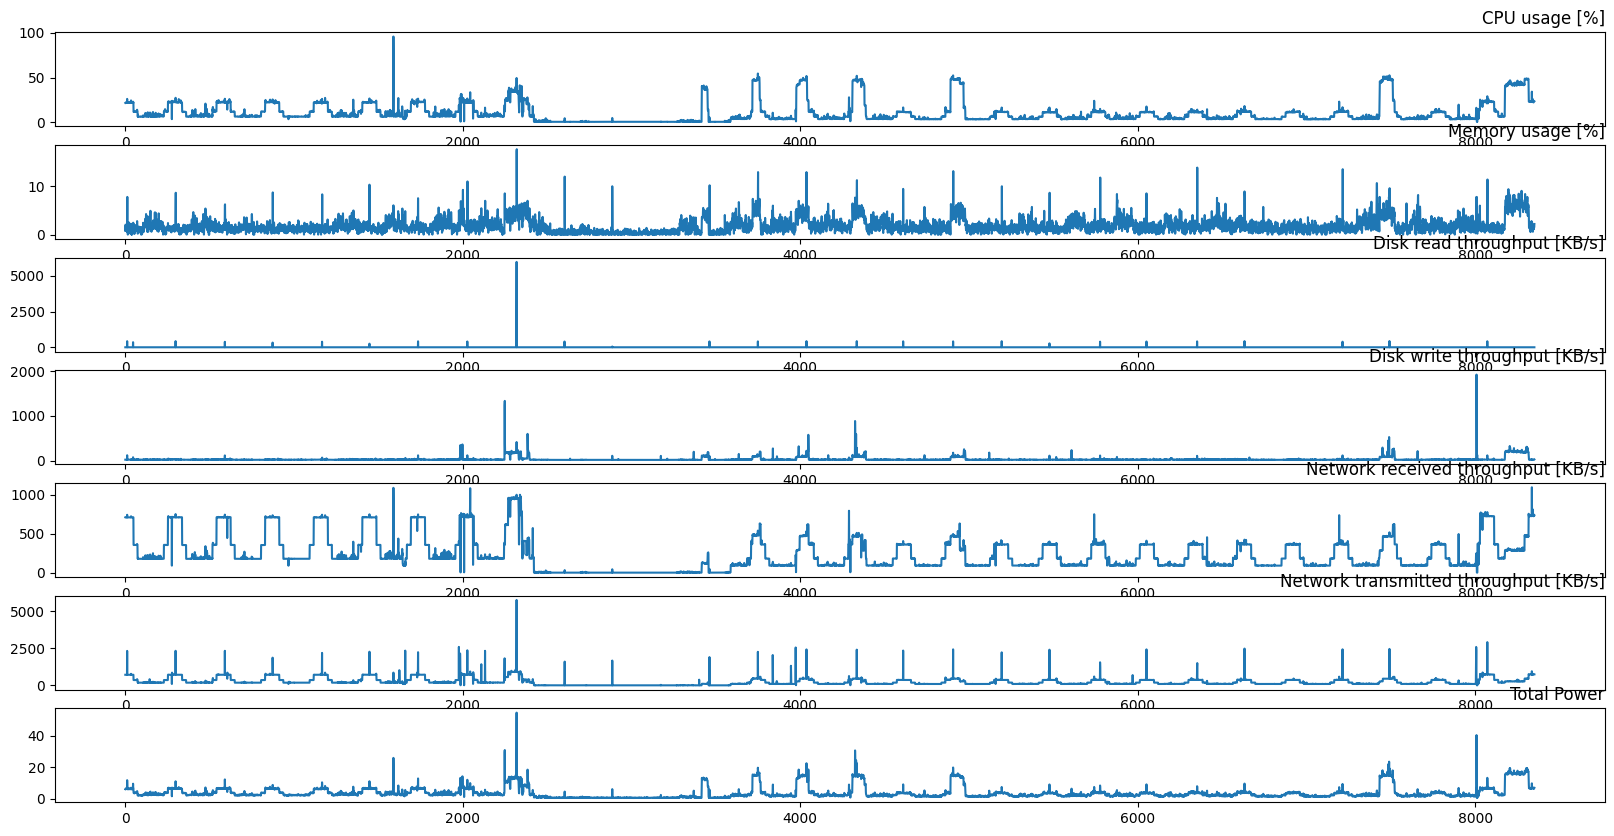

In [3]:
dataset = read_csv('gdrive/My Drive/archive/power_other.csv',header=0, index_col=0, engine='python')
values = dataset.values
groups = [0,1,2,3,4,5,6]
i = 1
pyplot.figure(figsize=(20,10))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=1, loc='right')
 i += 1
pyplot.show()

In [4]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data = series_to_supervised(scaled,2,1)
print(data)

      var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2      0.222468   0.044759        0.0   0.003150   0.647489   0.123588   
3      0.224045   0.116147        0.0   0.002625   0.646575   0.123240   
4      0.225728   0.112748        0.0   0.003150   0.647489   0.123588   
5      0.226044   0.044759        0.0   0.002625   0.646575   0.123414   
6      0.228253   0.044759        0.0   0.003150   0.647489   0.123588   
...         ...        ...        ...        ...        ...        ...   
8347   0.228989   0.078754        0.0   0.002625   0.661187   0.126021   
8348   0.228253   0.093484        0.0   0.002100   0.661187   0.126195   
8349   0.232565   0.093484        0.0   0.003150   0.671233   0.127238   
8350   0.234774   0.063456        0.0   0.002100   0.676712   0.127759   
8351   0.237194   0.090085        0.0   0.002625   0.667580   0.127064   

      var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t-1)  var6(t-1)  \
2      0.103282   0.224045   0.1

In [6]:
data.drop(data.columns[[-2,-3,-4,-5,-6,-7]], axis=1, inplace=True)
data.drop(data.columns[[6,13]], axis=1, inplace=True)

print (data.head())


   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2   0.222468   0.044759        0.0   0.003150   0.647489   0.123588   
3   0.224045   0.116147        0.0   0.002625   0.646575   0.123240   
4   0.225728   0.112748        0.0   0.003150   0.647489   0.123588   
5   0.226044   0.044759        0.0   0.002625   0.646575   0.123414   
6   0.228253   0.044759        0.0   0.003150   0.647489   0.123588   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var7(t)  
2   0.224045   0.116147        0.0   0.002625   0.646575   0.123240  0.110256  
3   0.225728   0.112748        0.0   0.003150   0.647489   0.123588  0.104503  
4   0.226044   0.044759        0.0   0.002625   0.646575   0.123414  0.105822  
5   0.228253   0.044759        0.0   0.003150   0.647489   0.123588  0.109800  
6   0.227306   0.090085        0.0   0.004199   0.648402   0.124109  0.107584  


In [7]:
values = data.values


# split into x and y dataset
values_x , values_y = values[:, :-1] , values[:, -1]

print (f"value_x shape is :{values_x.shape}")
print (f"value_y shape is :{values_y.shape}")
#split data to train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(values_x, values_y, test_size=0.3, shuffle=False)

# reshape input to be 3D [samples, timesteps, features]
"""x_train = x_train.reshape((  x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape(( x_test.shape[0], x_test.shape[1], 1))"""

x_train = x_train.reshape((x_train.shape[0], 2, 6))
x_test = x_test.reshape((x_test.shape[0], 2, 6))

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_train.size)
print (x_test.size)


value_x shape is :(8350, 12)
value_y shape is :(8350,)
(5845, 2, 6)
(5845,)
(2505, 2, 6)
(2505,)
70140
30060


# Prediction Model CNN-LSTM

In [8]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2, 6)))
model.add(Flatten())
model.add(Reshape((-1, 64)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


```
# This is formatted as code

#@title Default title text
model = 0


# define the model
model = Sequential()

# add convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[0], x_train.shape[1])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.summary()
# add LSTM layers

model.add(LSTM(100))





# add output layer
model.add(Dense(1,activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='mse')
```


In [10]:
print(model.output_shape)

(None, 1)


In [11]:
# fit the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))



Epoch 1/100
92/92 [==============================] - 5s 11ms/step - loss: 0.4054 - accuracy: 1.7109e-04 - val_loss: 0.2394 - val_accuracy: 0.0000e+00
Epoch 2/100
92/92 [==============================] - 1s 7ms/step - loss: 0.2004 - accuracy: 1.7109e-04 - val_loss: 0.2115 - val_accuracy: 0.0000e+00
Epoch 3/100
92/92 [==============================] - 1s 7ms/step - loss: 0.1949 - accuracy: 1.7109e-04 - val_loss: 0.2112 - val_accuracy: 0.0000e+00
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 0.1946 - accuracy: 1.7109e-04 - val_loss: 0.2111 - val_accuracy: 0.0000e+00
Epoch 5/100
92/92 [==============================] - 1s 9ms/step - loss: 0.1942 - accuracy: 1.7109e-04 - val_loss: 0.2109 - val_accuracy: 0.0000e+00
Epoch 6/100
92/92 [==============================] - 1s 11ms/step - loss: 0.1940 - accuracy: 1.7109e-04 - val_loss: 0.2109 - val_accuracy: 0.0000e+00
Epoch 7/100
92/92 [==============================] - 1s 11ms/step - loss: 0.1939 - accuracy: 1.7109e-04 

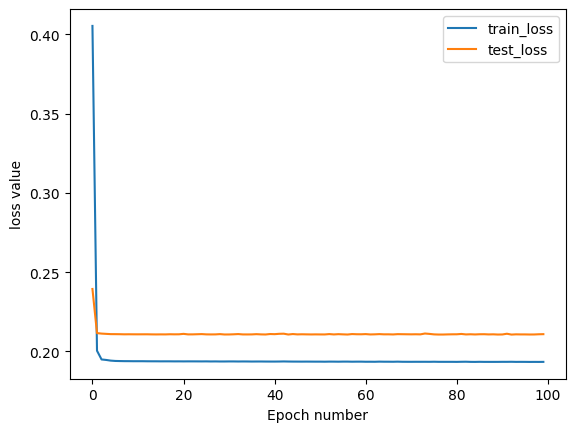

In [12]:
# plot history
fig,ax = pyplot.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='test_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
pyplot.show()

In [13]:
# make predictions
y_pred = model.predict(x_test)


79/79 [==============================] - 0s 2ms/step


In [14]:
accuracy = np.mean(y_pred.flatten() == y_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 0.00%


In [19]:
print (y_test.size)
print (y_pred.size)

2505
2505


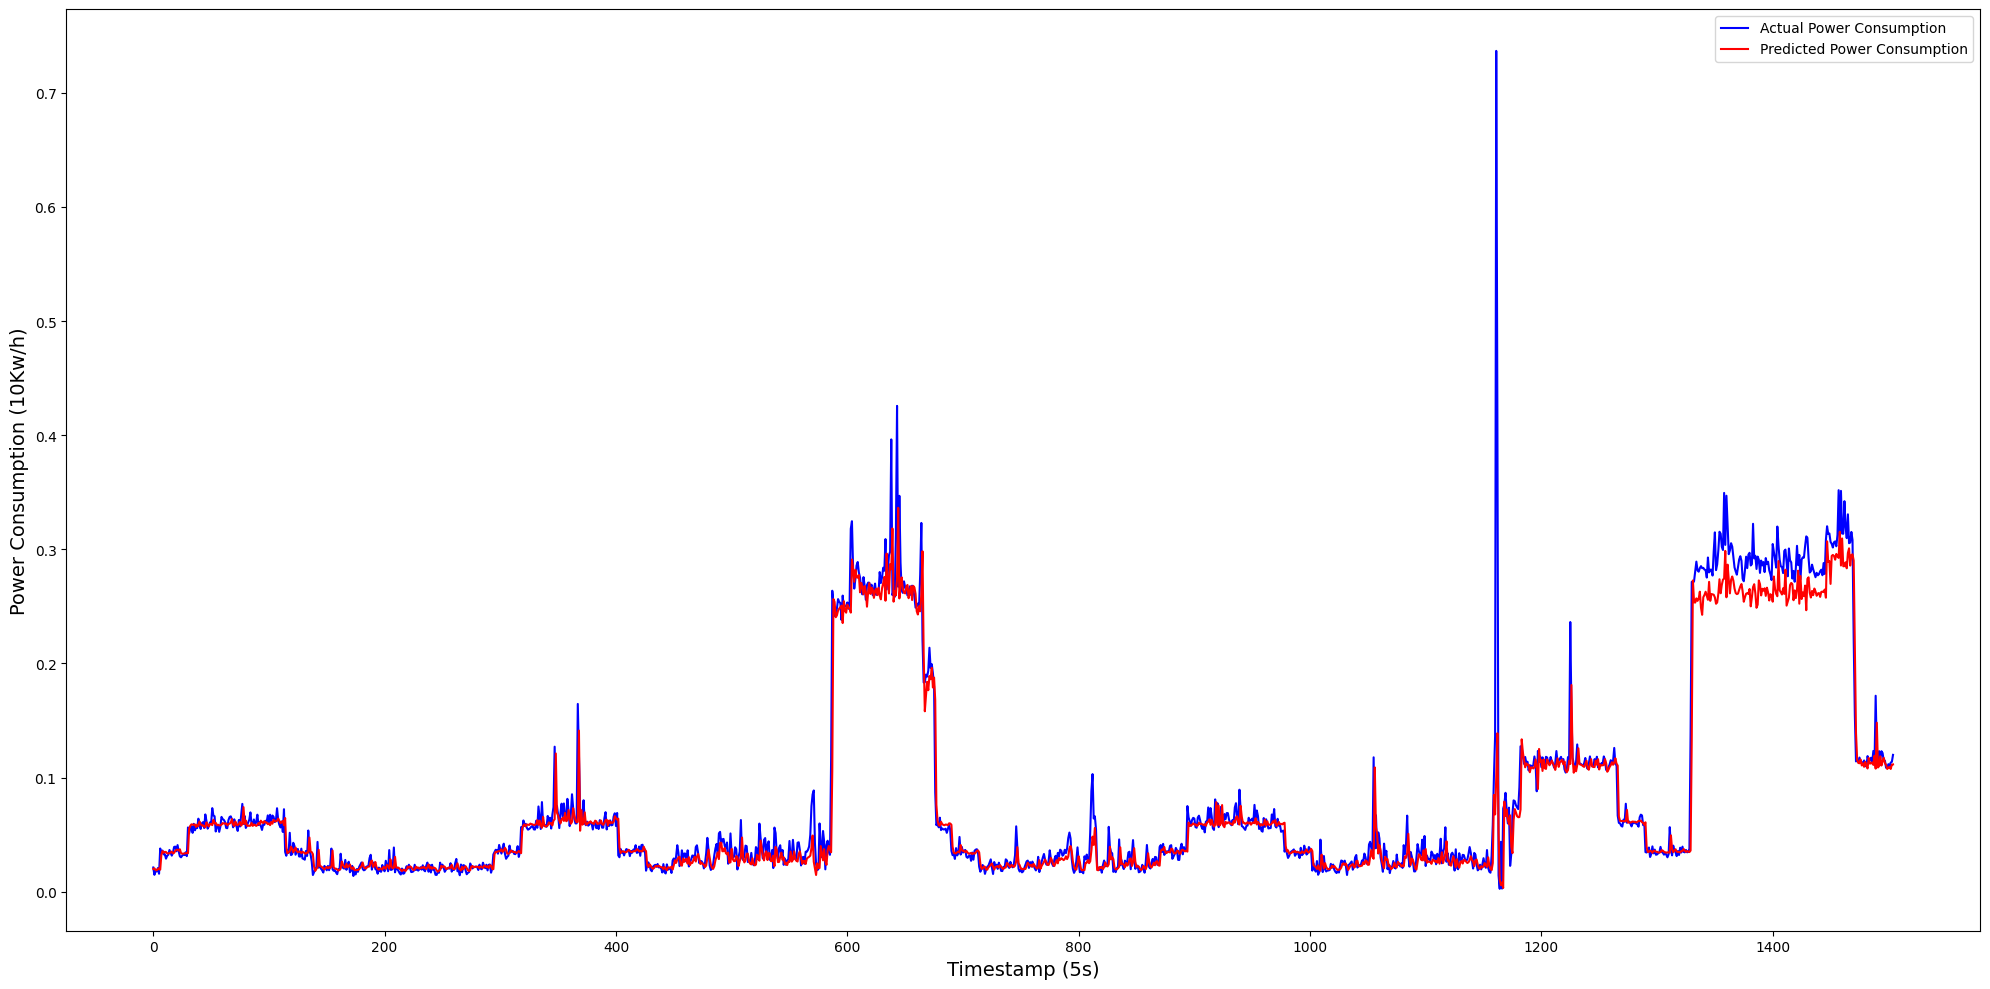

range(0, 2505) range(0, 2505)


In [21]:
a = range(len(y_pred))
b = range(len(y_test))
# Create a figure and axis
fig, ax = pyplot.subplots(figsize=(20, 10))

# Plot the actual data with a label and title
ax.plot(range(1505), y_test[1000:2505], 'b',label='Actual Power Consumption')
#ax.set_title('Actual Power Consumption', fontsize=16)  # Set title for the actual data

# Plot the predicted data with a label and title
ax.plot(range(1505), y_pred[1000:2505], 'r' ,label='Predicted Power Consumption')
#ax.set_title('Predicted Power Consumption', fontsize=16)  # Set title for the predicted data

# Set labels for x-axis and y-axis
ax.set_xlabel('Timestamp (5s)', fontsize=14)
ax.set_ylabel('Power Consumption (10Kw/h)', fontsize=14)

# Display legend
ax.legend()

# Adjust layout and display the plot
pyplot.tight_layout()
pyplot.show()

print (a,b)

In [16]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmae = sqrt(mean_absolute_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test RMAE: %.3f' % rmae)


Test RMSE: 0.020
Test RMAE: 0.091
